# Import bibliotek
Do wcześniej importowanych bibliotek dodajemy:
- **shutil** - moduł umożliwiający operacje na plikach
- **ultralytics** - biblioteka zawierająca implementację algorytmu YOLO

In [1]:
import pandas as pd
import xml.etree.ElementTree as xet
import os
from shutil import copy
from ultralytics import YOLO
print("imports succesfull")

imports succesfull


# Załadowanie danych
Używamy wcześniej przygotowanych danych zawierających informacje o bounding boxach.

In [20]:
df = pd.read_csv('labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,kaggle_dataset001/images\N1.xml,1093,1396,645,727
1,kaggle_dataset001/images\N100.xml,134,301,312,350
2,kaggle_dataset001/images\N101.xml,31,139,128,161
3,kaggle_dataset001/images\N102.xml,164,316,216,243
4,kaggle_dataset001/images\N103.xml,813,1067,665,724


# Przygotowanie danych
Algorytm YOLOv8 współrzędny bounding boxa podawane są w postaci:
- **center_x** - współrzędna x środka bounding boxa
- **center_y** - współrzędna y środka bounding boxa
- **bb_width** - szerokość bounding boxa
- **bb_height** - wysokość bounding boxa

Współrzędne te są podawane w odniesieniu do szerokości i wysokości obrazu.

In [21]:
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'kaggle_dataset001/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
0,kaggle_dataset001/images\N1.xml,1093,1396,645,727,kaggle_dataset001/images/N1.jpeg,1920,1080
1,kaggle_dataset001/images\N100.xml,134,301,312,350,kaggle_dataset001/images/N100.jpeg,450,417
2,kaggle_dataset001/images\N101.xml,31,139,128,161,kaggle_dataset001/images/N101.jpeg,249,239
3,kaggle_dataset001/images\N102.xml,164,316,216,243,kaggle_dataset001/images/N102.jpeg,478,395
4,kaggle_dataset001/images\N103.xml,813,1067,665,724,kaggle_dataset001/images/N103.jpeg,1800,1200


In [22]:
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,kaggle_dataset001/images\N1.xml,1093,1396,645,727,kaggle_dataset001/images/N1.jpeg,1920,1080,0.648177,0.635185,0.157812,0.075926
1,kaggle_dataset001/images\N100.xml,134,301,312,350,kaggle_dataset001/images/N100.jpeg,450,417,0.483333,0.793765,0.371111,0.091127
2,kaggle_dataset001/images\N101.xml,31,139,128,161,kaggle_dataset001/images/N101.jpeg,249,239,0.341365,0.604603,0.433735,0.138075
3,kaggle_dataset001/images\N102.xml,164,316,216,243,kaggle_dataset001/images/N102.jpeg,478,395,0.502092,0.581013,0.317992,0.068354
4,kaggle_dataset001/images\N103.xml,813,1067,665,724,kaggle_dataset001/images/N103.jpeg,1800,1200,0.522222,0.578750,0.141111,0.049167


In [23]:
df_train = df.iloc[:200]
df_test = df.iloc[200:]

## Przygotowanie danych dla algorytmu YOLO

Algorytm YOLO wymaga specjalnej struktury folderów:

- datasets
    - yolo_data_images
        - train
             - image1.jpg
             - image2.jpg
             - image1.txt
             - image2.txt
        - test
            - image3.jpg
             - image3.txt 

In [17]:
train_folder = './yolov8_data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = './yolov8_data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

# Trening modelu
Algorytm YOLOv8 wymaga pliku konfiguracyjnego w formacie yaml, który zawiera informacje o ścieżkach do danych treningowych i walidacyjnych, liczbie klas oraz ich nazwach.

Poniżej znajduje się plik konfiguracyjny:
```yaml
train: yolov8_data_images/train
val: yolov8_data_images/test
nc: 1
names: [
    'license_plate'
]
```
W celach testowych używamy najmniejszego modelu YOLOv8n.

In [26]:
data_file = 'data.yaml'
model = YOLO('yolov8n.pt')
model.train(data=data_file)

Ultralytics YOLOv8.2.5  Python-3.12.2 torch-2.3.0 CPU (AMD Ryzen 5 4600H with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:01<00:00, 600kB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\datasets\yolov8_data_images\train... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 759.16it/s]


train: New cache created: C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\datasets\yolov8_data_images\train.cache


val: Scanning C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\datasets\yolov8_data_images\test... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 768.15it/s]

val: New cache created: C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\datasets\yolov8_data_images\test.cache


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.378       3.39      1.306         19        640: 100%|██████████| 13/13 [01:10<00:00,  5.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]

                   all         25         25      0.278       0.84      0.774      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.187      1.889      1.087         20        640: 100%|██████████| 13/13 [01:05<00:00,  5.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

                   all         25         25    0.00639       0.96       0.87      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G       1.26      1.679      1.107         16        640: 100%|██████████| 13/13 [01:02<00:00,  4.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         25         25    0.00767       0.92       0.59       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.225      1.588      1.116         13        640: 100%|██████████| 13/13 [00:59<00:00,  4.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         25         25      0.851      0.457      0.775      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.194      1.463      1.131         21        640: 100%|██████████| 13/13 [01:00<00:00,  4.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

                   all         25         25      0.686      0.437      0.681       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.263      1.491      1.133         15        640: 100%|██████████| 13/13 [01:00<00:00,  4.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

                   all         25         25      0.465      0.523      0.402      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G       1.27      1.465       1.13         14        640: 100%|██████████| 13/13 [01:00<00:00,  4.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         25         25      0.973        0.6      0.668      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.238      1.435      1.147         13        640: 100%|██████████| 13/13 [01:00<00:00,  4.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         25         25      0.865       0.64      0.739       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.219      1.314      1.159         18        640: 100%|██████████| 13/13 [01:00<00:00,  4.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]

                   all         25         25      0.907       0.72      0.839      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.192      1.187      1.118         19        640: 100%|██████████| 13/13 [01:01<00:00,  4.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

                   all         25         25      0.824      0.748      0.847      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.146      1.174      1.124         16        640: 100%|██████████| 13/13 [01:00<00:00,  4.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

                   all         25         25      0.925       0.84       0.86      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.223      1.127      1.119         14        640: 100%|██████████| 13/13 [01:00<00:00,  4.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

                   all         25         25        0.9      0.716      0.803      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.197      1.064      1.094         18        640: 100%|██████████| 13/13 [01:00<00:00,  4.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

                   all         25         25      0.875      0.838       0.84      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.209      1.074      1.128         17        640: 100%|██████████| 13/13 [01:00<00:00,  4.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

                   all         25         25      0.884       0.64      0.774       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.252      1.061      1.152         15        640: 100%|██████████| 13/13 [00:59<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

                   all         25         25      0.754        0.8       0.78      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G       1.22      1.034      1.117         12        640: 100%|██████████| 13/13 [01:00<00:00,  4.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

                   all         25         25      0.622      0.659      0.593      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G       1.18      1.046      1.095         19        640: 100%|██████████| 13/13 [00:59<00:00,  4.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

                   all         25         25      0.826      0.569      0.713      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.158     0.9322      1.099         17        640: 100%|██████████| 13/13 [01:00<00:00,  4.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

                   all         25         25      0.944      0.678      0.827      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.152      0.925      1.103         14        640: 100%|██████████| 13/13 [01:00<00:00,  4.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all         25         25      0.952       0.88      0.908      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.188     0.9383      1.141         13        640: 100%|██████████| 13/13 [00:59<00:00,  4.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

                   all         25         25      0.953       0.92      0.922       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.227     0.9441      1.145         18        640: 100%|██████████| 13/13 [00:58<00:00,  4.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all         25         25          1      0.904       0.95      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.111     0.8196      1.094         14        640: 100%|██████████| 13/13 [00:57<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

                   all         25         25          1      0.792      0.893      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.136     0.8459      1.088         16        640: 100%|██████████| 13/13 [00:58<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

                   all         25         25      0.893       0.84      0.927      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.062     0.8149      1.077         19        640: 100%|██████████| 13/13 [00:58<00:00,  4.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

                   all         25         25      0.919      0.905      0.945       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.104     0.8097       1.08         15        640: 100%|██████████| 13/13 [00:58<00:00,  4.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all         25         25      0.922       0.95       0.97      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.021     0.7647      1.053         20        640: 100%|██████████| 13/13 [00:58<00:00,  4.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

                   all         25         25          1      0.959      0.975      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.024     0.7585      1.066         14        640: 100%|██████████| 13/13 [00:58<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]

                   all         25         25      0.947       0.92       0.98      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.055     0.7271      1.061         14        640: 100%|██████████| 13/13 [00:58<00:00,  4.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

                   all         25         25      0.991       0.92      0.983      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.039     0.7402       1.06         17        640: 100%|██████████| 13/13 [00:58<00:00,  4.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

                   all         25         25      0.987       0.92      0.976      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.053     0.7622      1.053         18        640: 100%|██████████| 13/13 [00:58<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]

                   all         25         25      0.922      0.951      0.976      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.081     0.7448      1.085         21        640: 100%|██████████| 13/13 [00:57<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

                   all         25         25      0.959      0.925      0.978      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.086     0.7705      1.102         16        640: 100%|██████████| 13/13 [00:57<00:00,  4.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]

                   all         25         25      0.956      0.876      0.939        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.021     0.7045      1.042         16        640: 100%|██████████| 13/13 [00:57<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

                   all         25         25      0.951       0.88      0.906      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.039       0.71      1.075         14        640: 100%|██████████| 13/13 [00:57<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

                   all         25         25      0.949       0.88      0.907      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.067     0.6975      1.076         13        640: 100%|██████████| 13/13 [00:57<00:00,  4.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]

                   all         25         25      0.952      0.795      0.878      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.017     0.6853       1.05         18        640: 100%|██████████| 13/13 [00:58<00:00,  4.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all         25         25      0.954      0.837      0.903      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.9739     0.6694      1.039         11        640: 100%|██████████| 13/13 [00:57<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

                   all         25         25      0.916      0.867       0.94      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G          1     0.6677      1.047         13        640: 100%|██████████| 13/13 [00:57<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]

                   all         25         25          1      0.838      0.972      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.019     0.6374      1.032         17        640: 100%|██████████| 13/13 [00:57<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

                   all         25         25          1      0.877       0.98      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.015     0.6432      1.037         20        640: 100%|██████████| 13/13 [00:57<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all         25         25      0.971       0.88      0.966      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.9623      0.639      1.022         20        640: 100%|██████████| 13/13 [00:56<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

                   all         25         25          1       0.84      0.942      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.9497     0.6337      1.031         16        640: 100%|██████████| 13/13 [00:57<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

                   all         25         25      0.937       0.92      0.972      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.9269      0.602      1.031         19        640: 100%|██████████| 13/13 [00:57<00:00,  4.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all         25         25      0.914      0.853      0.926      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.035     0.6496      1.079         21        640: 100%|██████████| 13/13 [00:57<00:00,  4.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all         25         25      0.982       0.84      0.871      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.9566     0.6279      1.021         17        640: 100%|██████████| 13/13 [01:00<00:00,  4.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

                   all         25         25          1      0.866      0.881      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.9663     0.5971     0.9981         13        640: 100%|██████████| 13/13 [00:59<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

                   all         25         25      0.978       0.84      0.889      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.9968     0.6178      1.063          9        640: 100%|██████████| 13/13 [00:59<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

                   all         25         25      0.941       0.88       0.91      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.9836     0.6144      1.037         21        640: 100%|██████████| 13/13 [01:00<00:00,  4.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

                   all         25         25      0.952       0.88      0.919      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.9393     0.5782      1.009         14        640: 100%|██████████| 13/13 [01:00<00:00,  4.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

                   all         25         25      0.955       0.92      0.942      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.9085     0.5903     0.9955         10        640: 100%|██████████| 13/13 [00:59<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all         25         25      0.914       0.92      0.941      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.9013     0.5764     0.9951         15        640: 100%|██████████| 13/13 [01:00<00:00,  4.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

                   all         25         25      0.871       0.92      0.933       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.9388     0.5721     0.9879         16        640: 100%|██████████| 13/13 [01:00<00:00,  4.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

                   all         25         25      0.916      0.873      0.932      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.9497       0.59      1.029         15        640: 100%|██████████| 13/13 [01:07<00:00,  5.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

                   all         25         25      0.988       0.84       0.94      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      0.898     0.5636     0.9914         11        640: 100%|██████████| 13/13 [01:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all         25         25      0.995       0.88      0.939      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.8751     0.5594     0.9907         21        640: 100%|██████████| 13/13 [01:05<00:00,  5.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

                   all         25         25      0.948       0.88      0.925      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.8576     0.5451     0.9679         13        640: 100%|██████████| 13/13 [01:04<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all         25         25      0.948       0.88      0.905      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.8595     0.5516     0.9726         21        640: 100%|██████████| 13/13 [01:04<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

                   all         25         25      0.948       0.88      0.933      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.8227     0.5258     0.9675         14        640: 100%|██████████| 13/13 [01:04<00:00,  4.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all         25         25      0.982       0.88      0.922      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.8536     0.5468      0.974         15        640: 100%|██████████| 13/13 [01:04<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all         25         25      0.971       0.88      0.916      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.8382     0.5538     0.9815         13        640: 100%|██████████| 13/13 [01:04<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

                   all         25         25      0.956       0.92      0.917      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.8248     0.5334     0.9712         13        640: 100%|██████████| 13/13 [01:04<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

                   all         25         25      0.958      0.918      0.917      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.8186     0.5154     0.9466         15        640: 100%|██████████| 13/13 [01:05<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all         25         25      0.951       0.88      0.934      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.8264     0.5395     0.9704         22        640: 100%|██████████| 13/13 [01:05<00:00,  5.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

                   all         25         25      0.955       0.88      0.932      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.8109     0.5193     0.9509         15        640: 100%|██████████| 13/13 [01:04<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all         25         25      0.948       0.88      0.904      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.7929     0.4982     0.9585         16        640: 100%|██████████| 13/13 [01:07<00:00,  5.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

                   all         25         25      0.953       0.88      0.904      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.7948     0.5188     0.9714         14        640: 100%|██████████| 13/13 [01:08<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]

                   all         25         25      0.956      0.869       0.89      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.8484      0.514     0.9887         18        640: 100%|██████████| 13/13 [01:03<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

                   all         25         25          1      0.838      0.895      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.8117     0.5164     0.9698         14        640: 100%|██████████| 13/13 [01:04<00:00,  4.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all         25         25      0.915       0.88      0.892      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.7488     0.4712      0.943         11        640: 100%|██████████| 13/13 [01:03<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         25         25      0.913       0.88      0.927      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.7902     0.4858     0.9723         15        640: 100%|██████████| 13/13 [01:04<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

                   all         25         25          1      0.876      0.943      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.7839     0.4895     0.9714         18        640: 100%|██████████| 13/13 [01:05<00:00,  5.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]

                   all         25         25      0.988       0.88       0.94      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.7684      0.484     0.9432         17        640: 100%|██████████| 13/13 [01:04<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         25         25          1      0.877      0.917      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      0.757      0.491     0.9425         21        640: 100%|██████████| 13/13 [01:03<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

                   all         25         25      0.976       0.88      0.918      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      0.725     0.4619     0.9301         19        640: 100%|██████████| 13/13 [01:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

                   all         25         25      0.984       0.88      0.919      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.7307     0.4697     0.9322         11        640: 100%|██████████| 13/13 [01:03<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all         25         25      0.998       0.88      0.916      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.7621     0.4661      0.932         19        640: 100%|██████████| 13/13 [01:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all         25         25      0.955       0.88      0.921      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      0.726     0.4737     0.9364         21        640: 100%|██████████| 13/13 [01:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

                   all         25         25       0.92      0.915      0.932      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.7399     0.4727     0.9355         17        640: 100%|██████████| 13/13 [01:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

                   all         25         25      0.957       0.92      0.949      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      0.722     0.4573     0.9353         19        640: 100%|██████████| 13/13 [01:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

                   all         25         25      0.956       0.88      0.949      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.6948     0.4536     0.9436         16        640: 100%|██████████| 13/13 [01:04<00:00,  4.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all         25         25      0.979       0.88       0.94      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.7255     0.4574     0.9453         22        640: 100%|██████████| 13/13 [01:05<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         25         25      0.981       0.88      0.941      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      0.699     0.4544     0.9381         21        640: 100%|██████████| 13/13 [01:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all         25         25       0.95       0.88      0.931      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      0.693     0.4309     0.9407         11        640: 100%|██████████| 13/13 [01:04<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]

                   all         25         25      0.949       0.88      0.923      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.7228     0.4309     0.9429         13        640: 100%|██████████| 13/13 [01:04<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

                   all         25         25      0.953       0.88      0.935      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.7192     0.4352     0.9365          9        640: 100%|██████████| 13/13 [01:04<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

                   all         25         25      0.953       0.88      0.935      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.7198     0.4276     0.9486         14        640: 100%|██████████| 13/13 [01:04<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

                   all         25         25      0.952       0.88       0.93      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.6796     0.4318     0.9129         14        640: 100%|██████████| 13/13 [01:04<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

                   all         25         25      0.952       0.88      0.919       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.6525     0.4301      0.917         17        640: 100%|██████████| 13/13 [01:05<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

                   all         25         25       0.95       0.88      0.916      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.6694     0.4279     0.9082         14        640: 100%|██████████| 13/13 [01:05<00:00,  5.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         25         25      0.953       0.88      0.929      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.6349     0.4235     0.9091         19        640: 100%|██████████| 13/13 [01:04<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]

                   all         25         25      0.954       0.88      0.929      0.668


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G       0.65     0.4383     0.9076          8        640: 100%|██████████| 13/13 [01:04<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

                   all         25         25      0.953       0.88      0.933       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.6006     0.3851     0.9054          8        640: 100%|██████████| 13/13 [01:04<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all         25         25      0.953       0.88      0.938      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.5934     0.3985      0.893          8        640: 100%|██████████| 13/13 [01:04<00:00,  4.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all         25         25      0.952       0.88       0.94       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.5942     0.3965     0.8792          8        640: 100%|██████████| 13/13 [01:05<00:00,  5.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]

                   all         25         25      0.951       0.88      0.943      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.6169     0.3899      0.908          8        640: 100%|██████████| 13/13 [01:03<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

                   all         25         25      0.948       0.88       0.95      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.5878     0.3759     0.8801          8        640: 100%|██████████| 13/13 [01:04<00:00,  4.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

                   all         25         25      0.958      0.917      0.956      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.5906     0.3648     0.8777          8        640: 100%|██████████| 13/13 [01:03<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         25         25      0.958      0.919      0.957      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.5874      0.372     0.8994          8        640: 100%|██████████| 13/13 [01:04<00:00,  4.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

                   all         25         25      0.958      0.918      0.957      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      0.589     0.3777     0.8887          8        640: 100%|██████████| 13/13 [01:03<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all         25         25      0.958      0.917      0.956      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.5557     0.3692     0.8649          8        640: 100%|██████████| 13/13 [01:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]

                   all         25         25      0.958       0.88      0.954      0.672



100 epochs completed in 1.817 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 6.3MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics YOLOv8.2.5  Python-3.12.2 torch-2.3.0 CPU (AMD Ryzen 5 4600H with Radeon Graphics)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


                   all         25         25      0.958      0.918      0.957      0.689
Speed: 3.8ms preprocess, 92.0ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train9


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022DFD3E87D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

Zapisujemy model w formanie onnx co pozwoli na jego wykorzystanie w innych środowiskach.

In [28]:
path = model.export(format="onnx")

Ultralytics YOLOv8.2.5  Python-3.12.2 torch-2.3.0 CPU (AMD Ryzen 5 4600H with Radeon Graphics)

PyTorch: starting from 'runs\detect\train9\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ---------------------------------------- 14.4/14.4 MB 571.2 kB/s eta 0:00:00

requirements: AutoUpdate success  45.2s, installed 1 package: ['onnx>=1.12.0']
requirements:  Restart runtime or rerun command for updates to take effect

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success  46.2s, saved as 'runs\detect\train9\weights\best.onnx' (11.7 MB)

Export complete (48.3s)
Results saved to C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\runs\detect\train9\weights
Predict:         yolo predict task=detect model=runs\detect\train9\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs\detect\train9\weights\

# Wczytanie modelu 

In [3]:
model = YOLO('runs/detect/train9/weights/best.onnx')

In [4]:
results = model('my_hq_photos/licence001.jpg')  # perform inference
results[0].show()

Loading runs\detect\train9\weights\best.onnx for ONNX Runtime inference...
image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\my_hq_photos\licence001.jpg: 640x640 1 license_plate, 61.6ms
Speed: 29.0ms preprocess, 61.6ms inference, 1210.4ms postprocess per image at shape (1, 3, 640, 640)


In [5]:
import cv2
import pytesseract as pt
import matplotlib.pyplot as plt
pt.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
print("import necessery libraries and adding pytesseract path")

import necessery libraries and adding pytesseract path


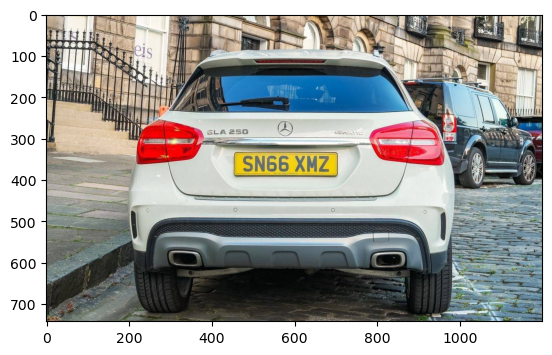

In [17]:
img = plt.imread("my_hq_photos/licence083.jpg")
plt.imshow(img)
plt.show()

# Tworzenie Pipeline'u
Definujemy funkcję, która przyjmuje ścieżkę do pliku z obrazem, a następnie wykonuje na nim detekcję obiektów. Po wykryciu obiektu, wycinamy go z obrazu i przekazujemy do funkcji pytesseract, która zwraca tekst z obrazu.

In [18]:
def object_detection(filepath, model):
    # Perform inference
    results = model(filepath)
    
    img = cv2.imread(filepath)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.show()
    
    # Extract bounding box of the first detected license plate
    if len(results[0].boxes) == 0:
        return "no number"
    cords = results[0].boxes[0].xyxy.tolist()
    x1, y1, x2, y2 = cords[0]

    # Extract the area of interest (license plate)
    license_plate_img = img[int(y1):int(y2), int(x1):int(x2)]
    
    gray = cv2.cvtColor(license_plate_img, cv2.COLOR_BGR2GRAY)
    
    plt.imshow(cv2.cvtColor(license_plate_img, cv2.COLOR_BGR2GRAY), cmap='gray')
    plt.show()
    
    text = pt.image_to_string(gray, config='--psm 7 --oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ ')
    text = text.strip()

    return text

image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\my_hq_photos\licence083.jpg: 640x640 1 license_plate, 68.6ms
Speed: 4.0ms preprocess, 68.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)


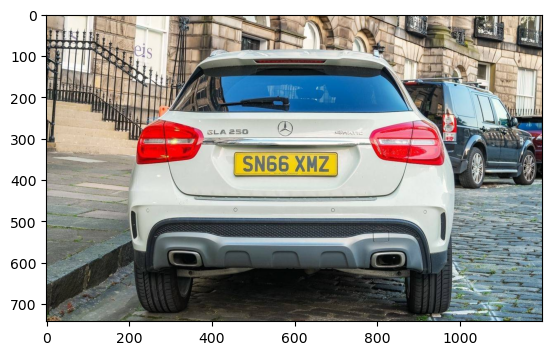

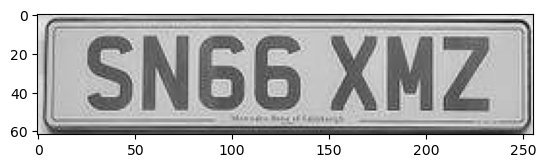

numer tablicy: SNG6GXMZ


In [19]:
path = "my_hq_photos/licence083.jpg"
text = object_detection(path, model)
print("numer tablicy:", text)

image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\kaggle_dataset001\TEST\TEST.jpeg: 640x640 1 license_plate, 44.6ms
Speed: 4.0ms preprocess, 44.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


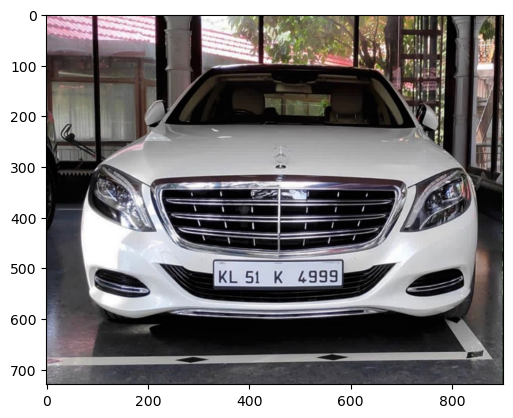

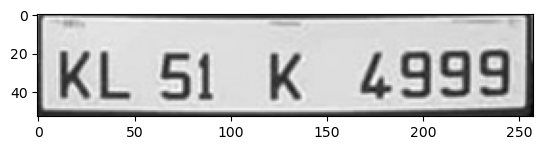

numer tablicy: KL51K4999


In [13]:
path = "kaggle_dataset001/TEST/TEST.jpeg"
text = object_detection(path, model)
print("numer tablicy:", text)

image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\my_hq_photos\licence001.jpg: 640x640 1 license_plate, 52.6ms
Speed: 4.0ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


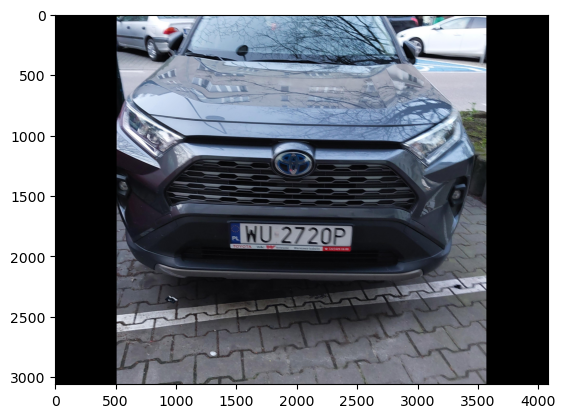

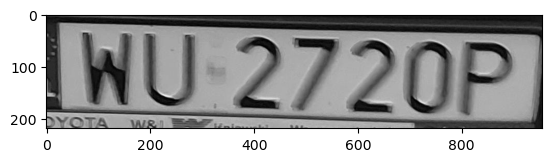

numer tablicy: 1WU2720P


In [14]:
path = "my_hq_photos/licence001.jpg"
text = object_detection(path, model)
print("numer tablicy:", text)